# Example for the Beijing Air Quality 2.5 Dataset

https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data

In [41]:
import dill

import numpy as np
import pandas as pd

import tensorflow as tf

from tensorflow.keras import datasets, layers, models

from matplotlib import pyplot as plt
from IPython.display import clear_output

In [28]:
class PlotLosses(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label='loss')
        plt.plot(self.x, self.val_losses, label='val_loss')
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

In [29]:
dataset_link = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv'
df = pd.read_csv(dataset_link)

print(len(df), len(df.dropna()))

df_temp = df.copy()
df_temp = df_temp.dropna()
df_temp = df_temp.reset_index()


# df['Datetime'] = pd.to_datetime(df[['day', 'month', 'year']]) + pd.to_timedelta(df['hour'], 'h')

df_temp = df_temp.drop(['index', 'No', 'day', 'month', 'year', 'hour'], axis=1)
df_temp['cbwd'] = df_temp['cbwd'].astype('category').cat.codes

epochs = 250

normalize = False
standardize = True

min_max_dict = {}
std_mean_dict = {}

if normalize:

    for feature_name in df_temp.columns:
        max_value = df_temp[feature_name].max()
        min_value = df_temp[feature_name].min()

        df_temp[feature_name] = (df_temp[feature_name] - min_value) / (max_value - min_value)
        
        min_max_dict[feature_name] = {'max': max_value, 'min': min_value}
        
elif standardize:

    for feature_name in df_temp.columns:
        std_value = df_temp[feature_name].std()
        mean_value = df_temp[feature_name].mean()

        df_temp[feature_name] = (df_temp[feature_name] - mean_value) / std_value
        
        std_mean_dict[feature_name] = {'std': std_value, 'mean': mean_value}

43824 41757


In [30]:
df_temp.iloc[:10]

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,0.330110,-1.229777,-1.347127,0.345325,0.358837,-0.444939,-0.071056,-0.137407
1,0.536519,-1.160494,-1.347127,0.345325,0.358837,-0.427002,-0.071056,-0.137407
2,0.656019,-0.883364,-1.429261,0.442406,0.358837,-0.409064,-0.071056,-0.137407
3,0.895018,-0.606234,-1.429261,0.539486,0.358837,-0.372988,1.212847,-0.137407
4,0.427883,-0.606234,-1.429261,0.539486,0.358837,-0.355051,2.496751,-0.137407
5,0.112838,-0.606234,-1.511395,0.539486,0.358837,-0.337114,3.780654,-0.137407
6,0.069384,-0.606234,-1.511395,0.636567,0.358837,-0.301038,5.064558,-0.137407
7,0.275792,-0.606234,-1.429261,0.733647,0.358837,-0.264962,-0.071056,-0.137407
8,0.232338,-0.675516,-1.511395,0.733647,0.358837,-0.228886,-0.071056,-0.137407
9,0.362701,-0.606234,-1.429261,0.830728,0.358837,-0.192810,-0.071056,-0.137407


In [31]:
train_size = int(len(df_temp) * 0.8)

train = df_temp.iloc[:train_size]
test = df_temp.iloc[train_size + 1:]

X_train = train.drop(['pm2.5'], axis=1)
y_train = train['pm2.5']

X_test = test.drop(['pm2.5'], axis=1)
y_test = test['pm2.5']

print(len(train), len(test))
print(len(X_train), len(y_train), len(X_test), len(y_test))

33405 8351
33405 33405 8351 8351


In [32]:
def create_sequences(X, y, n_steps=24):
    dataset_X = []
    dataset_y = []
    
    for i in range(len(X) - (n_steps + 2)):        
        dataset_X.append(X.iloc[i:i + n_steps].values)
        dataset_y.append(y.iloc[i + n_steps + 1])
        
    return np.asarray(dataset_X), np.asarray(dataset_y)

In [33]:
dataset_train = create_sequences(X_train, y_train)
dataset_test = create_sequences(X_test, y_test)

In [34]:
cnn_model = models.Sequential()
cnn_model.add(layers.Conv1D(32, 3, activation='relu', input_shape=(24, 7)))
cnn_model.add(layers.MaxPooling1D(2))
cnn_model.add(layers.Conv1D(64, 3, activation='relu'))
cnn_model.add(layers.MaxPooling1D(2))
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(100, activation='relu'))
cnn_model.add(layers.Dropout(0.3))
cnn_model.add(layers.Dense(50, activation='relu'))
cnn_model.add(layers.Dropout(0.3))
cnn_model.add(layers.Dense(1))

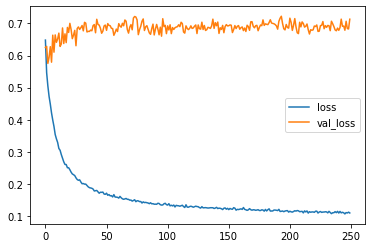

In [35]:
rmse = tf.keras.metrics.RootMeanSquaredError()

cnn_model.compile(optimizer='adam', loss='mse', metrics=[rmse])

history = cnn_model.fit(dataset_train[0], dataset_train[1], epochs=epochs, validation_data=(dataset_test[0], dataset_test[1]), verbose=0, callbacks=[plot_losses])

In [36]:
dnn_model = models.Sequential()
dnn_model.add(layers.Flatten())
dnn_model.add(layers.Dense(500, activation='relu'))
dnn_model.add(layers.Dropout(0.3))
dnn_model.add(layers.Dense(250, activation='relu'))
dnn_model.add(layers.Dropout(0.3))
dnn_model.add(layers.Dense(100, activation='relu'))
dnn_model.add(layers.Dropout(0.3))
dnn_model.add(layers.Dense(1))

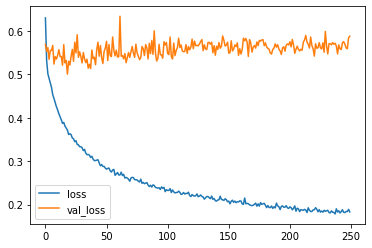

In [37]:
rmse = tf.keras.metrics.RootMeanSquaredError()

dnn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=[rmse])

history = dnn_model.fit(dataset_train[0], dataset_train[1], epochs=epochs, validation_data=(dataset_test[0], dataset_test[1]), verbose=0, callbacks=[plot_losses])

In [1]:
rnn_model = models.Sequential()
rnn_model.add(layers.LSTM(32, return_sequences=True))
rnn_model.add(layers.Flatten())
rnn_model.add(layers.Dense(100, activation='relu'))
rnn_model.add(layers.Dropout(0.3))
rnn_model.add(layers.Dense(1))

NameError: name 'models' is not defined

In [ ]:
rmse = tf.keras.metrics.RootMeanSquaredError()

rnn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=[rmse])

history = rnn_model.fit(dataset_train[0], dataset_train[1], epochs=epochs, validation_data=(dataset_test[0], dataset_test[1]), verbose=0, callbacks=[plot_losses])

In [43]:
cnn_model.save('./beijing_air_2_5_cnn_model.h5')
dnn_model.save('./beijing_air_2_5_dnn_model.h5')
rnn_model.save('./beijing_air_2_5_rnn_model.h5')

with open('./beijing_air_2_5_test_data.dill', 'wb') as f:
    dill.dump(dataset_test, f)